In [1]:
# %env ALL_PROXY=http://127.0.0.1:33001
# %env HTTP_PROXY=http://127.0.0.1:33001
# %env HTTPS_PROXY=http://127.0.0.1:33001
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [2]:
# !curl google.com

# Import

If change the model, in training step, you need to 
1. change the log chapter
2. change the model code

In [3]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import albumentations as A
import segmentation_models_pytorch as smp

from tqdm import tqdm
from torch.utils.data import DataLoader
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import KFold, train_test_split

import wandb

c:\Users\laish\miniconda3\envs\dpln310\lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
import sys
# sys.path.insert(0, "/root/Soil-Column-Procedures")
sys.path.insert(0, "c:/Users/laish/1_Codes/Image_processing_toolchain/")

from src.API_functions.DL import load_data, log, seed, evaluate
from src.API_functions.Images import file_batch as fb
from src.API_functions.Soils import pre_process
from src.workflow_tools.model_online import fr_unet

# Hyperparameter and log

In [5]:
my_parameters = {
    'seed': 888,

    'Kfold': None,
    'ratio': 0.25,

    'model': 'DeepLabv3+',   # model = 'U-Net', 'DeepLabv3+', 'PSPNet'
    'optimizer': 'adam',
    'learning_rate': 0.001,  # Initial learning rate
    'scheduler': 'reduce_on_plateau',  # Type of scheduler
    'scheduler_patience': 10,  # Number of epochs to wait before reducing LR
    'scheduler_factor': 0.5,  # Factor by which to reduce LR
    'scheduler_min_lr': 1e-6,  # Minimum learning rate
    'batch_size': 8,
    'loss_function': 'cross_entropy',

    'n_epochs': 1000,
    'patience': 50,

    'wandb': '28.using_fr_unet'
}

device = 'cuda'
mylogger = log.DataLogger('wandb')  # 'wandb' or 'all'

seed.stablize_seed(my_parameters['seed'])

# Transform

In [6]:
# For training data
transform_train = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=90, p=0.5),
    A.GaussNoise(p=0.5),
    # A.OpticalDistortion(p=0.5),
    ToTensorV2(),
], seed=my_parameters['seed'])

# For validation and test data
transform_val = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=90, p=0.5),
    A.GaussNoise(p=0.5),
    ToTensorV2(),
], seed=my_parameters['seed'])

# Model

In [7]:
# model = smp.PSPNet(
#     encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#     encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
#     in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#     classes=1,                      # model output channels (number of classes in your dataset)
# )
# model = model.to(device)

In [8]:
# model = smp.Unet(
#     encoder_name="efficientnet-b0",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#     encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
#     in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#     classes=1,                      # model output channels (number of classes in your dataset)
# )
# model = model.to(device)

In [9]:
# model = smp.DeepLabV3Plus(
#     encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#     encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
#     in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#     classes=1,                      # model output channels (number of classes in your dataset)
# )

# model.load_state_dict(torch.load(f"c:/Users/laish/1_Codes/Image_processing_toolchain/src/workflow_tools/model_DeepLabv3+_23.drive_again.pth", weights_only=True))

In [10]:
model = fr_unet.FR_UNet(num_channels=1, num_classes=1, feature_scale=2, dropout=0.2, fuse=True, out_ave=True)
model = model.to(device)

In [11]:

# Freeze encoder parameters
# for param in model.encoder.parameters():
    # param.requires_grad = False

# model = model.to(device)

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=my_parameters['learning_rate'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=my_parameters['scheduler_factor'],
    patience=my_parameters['scheduler_patience'],
    min_lr=my_parameters['scheduler_min_lr']
)
criterion = evaluate.DiceBCELoss()

# Train

The codes below are only for training.

In test step, you need to proceed the codes above and the test chapter code.

## Wandb

In [13]:
wandb.init(
    project="U-Net",
    name=my_parameters['wandb'],
    config=my_parameters,
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: laishixuan123 (laishixuan123-china-agricultural-university). Use `wandb login --relogin` to force relogin


## Load_data

In [13]:
# data_paths = fb.get_image_names(r'f:\3.Experimental_Data\Core_datasets\Batches\5.Precheck\image', None, 'tif')
# labels_paths = fb.get_image_names(r'f:\3.Experimental_Data\Core_datasets\Batches\5.Precheck\label', None, 'tif')

# data = fb.read_images(data_paths, 'gray', read_all=True)
# labels = fb.read_images(labels_paths, 'gray', read_all=True)

In [14]:
# def histogram_equalization_float32(image):
#     """
#     Perform histogram equalization on a float32 image with values in the range [0, 1],
#     ignoring pixels with values exactly 0 or 1.

#     Parameters:
#         image (numpy.ndarray): Input float32 image with values in [0, 1].

#     Returns:
#         numpy.ndarray: Histogram-equalized image with values in [0, 1].
#     """
#     if not (image.dtype == np.float32 and image.min() >= 0.0 and image.max() <= 1.0):
#         raise ValueError("Input image must be a float32 array with values in the range [0, 1].")

#     # Create a mask to exclude pixels with values 0 or 1
#     mask = (image > 0) & (image < 1)
#     valid_pixels = image[mask]

#     # Compute histogram and cumulative distribution function (CDF) for valid pixels
#     hist, bin_edges = np.histogram(valid_pixels, bins=65536, range=(0, 1), density=False)
#     cdf = hist.cumsum()
#     cdf_normalized = cdf / cdf[-1]  # Normalize to range [0, 1]

#     # Use linear interpolation to map original pixel values to equalized values
#     equalized = np.zeros_like(image, dtype=np.float32)
#     equalized[mask] = np.interp(valid_pixels, bin_edges[:-1], cdf_normalized)

#     return equalized

57 images have been found in g:\DL_Data_raw\version4-classes\5.precheck_train_val\image
The first 3 images are:
g:\DL_Data_raw\version4-classes\5.precheck_train_val\image\0003-02130-patch-00000.tif
g:\DL_Data_raw\version4-classes\5.precheck_train_val\image\0003-02130-patch-00001.tif
g:\DL_Data_raw\version4-classes\5.precheck_train_val\image\0003-02130-patch-00002.tif
Get names completely!
57 images have been found in g:\DL_Data_raw\version4-classes\5.precheck_train_val\label
The first 3 images are:
g:\DL_Data_raw\version4-classes\5.precheck_train_val\label\0003-02130-patch-00000.tif
g:\DL_Data_raw\version4-classes\5.precheck_train_val\label\0003-02130-patch-00001.tif
g:\DL_Data_raw\version4-classes\5.precheck_train_val\label\0003-02130-patch-00002.tif
Get names completely!


100%|██████████| 57/57 [00:00<00:00, 585.29it/s]


57 images have been read
Reading completely!


100%|██████████| 57/57 [00:00<00:00, 833.52it/s]


57 images have been read
Reading completely!


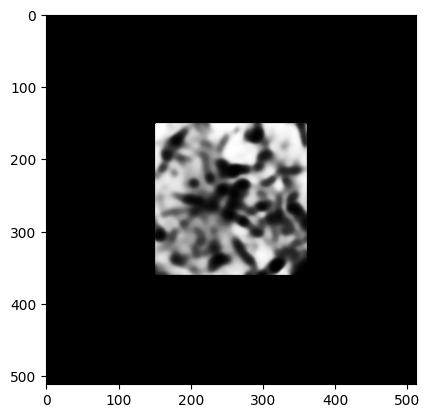

In [14]:
data_paths = fb.get_image_names(r'g:\DL_Data_raw\version4-classes\5.precheck_train_val\image', None, 'tif')
labels_paths = fb.get_image_names(r'g:\DL_Data_raw\version4-classes\5.precheck_train_val\label', None, 'tif')
# data_paths = fb.get_image_names('/mnt/images/', None, 'tif')
# labels_paths = fb.get_image_names('/mnt/labels/', None, 'tif')

data = fb.read_images(data_paths, 'gray', read_all=True)
labels = fb.read_images(labels_paths, 'gray', read_all=True)

for i in range(len(data)):
    data[i] = pre_process.median(data[i], kernel_size=3)
    data[i] = pre_process.histogram_equalization_float32(data[i])

# Using plt to show the first img in gray
import matplotlib.pyplot as plt
plt.imshow(data[30], cmap='gray', vmin=0, vmax=1)


In [15]:
train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=my_parameters['ratio'], random_state=my_parameters['seed'])


train_dataset = load_data.my_Dataset(train_data, train_labels, transform=transform_train)
val_dataset = load_data.my_Dataset(val_data, val_labels, transform=transform_val)


train_loader = DataLoader(train_dataset, batch_size=my_parameters['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=my_parameters['batch_size'], shuffle=False)


print(f'len of train_data: {len(train_data)}, len of val_data: {len(val_data)}')

len of train_data: 42, len of val_data: 15


## Train

In [ ]:
val_loss_best = 100000
proceed_once = True  # Add a flag

for epoch in range(my_parameters['n_epochs']):
    model.train()
    train_loss = 0.0

    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)

        # Checking the dimension of the outputs and labels
        if outputs.dim() == 4 and outputs.size(1) == 1:
            outputs = outputs.squeeze(1)
        
        # Only proceed once:
        if proceed_once:
            print(f'outputs.size(): {outputs.size()}, labels.size(): {labels.size()}')
            print(f'outputs.min: {outputs.min()}, outputs.max: {outputs.max()}')
            print(f'images.min: {images.min()}, images.max: {images.max()}')
            print(f'labels.min: {labels.min()}, labels.max: {labels.max()}')
            print(f'count of label 0: {(labels == 0).sum()}, count of label 1:{(labels == 1).sum()}')
            print('')
            proceed_once = False  # Set the flag to False after proceeding once
        
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
    
    train_loss_mean = train_loss / len(train_loader.dataset)


    model.eval()
    val_loss = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            if outputs.dim() == 4 and outputs.size(1) == 1:
                outputs = outputs.squeeze(1)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)

    val_loss_mean = val_loss / len(val_loader.dataset)
    current_lr = optimizer.param_groups[0]['lr']
    dict = {
        'train_loss': train_loss_mean,
        'epoch': epoch,
        'val_loss': val_loss_mean,
        'learning_rate': current_lr
    }
    mylogger.log(dict)

    # Step the scheduler
    scheduler.step(val_loss_mean)

    if val_loss_mean < val_loss_best:
        val_loss_best = val_loss_mean
        torch.save(model.state_dict(), f"model_{my_parameters['model']}_{my_parameters['wandb']}.pth")
        print(f'Model saved at epoch {epoch:.3f}, val_loss: {val_loss_mean:.3f}')

  0%|          | 0/6 [00:00<?, ?it/s]c:\Users/laish/1_Codes/Image_processing_toolchain\src\API_functions\DL\load_data.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float32)
c:\Users/laish/1_Codes/Image_processing_toolchain\src\API_functions\DL\load_data.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float32)


outputs.size(): torch.Size([8, 512, 512]), labels.size(): torch.Size([8, 512, 512])
outputs.min: -1.440513253211975, outputs.max: 0.9538716673851013
images.min: 0.0, images.max: 1.0
labels.min: 0.0, labels.max: 1.0
count of label 0: 2024702, count of label 1:72450



100%|██████████| 6/6 [07:49<00:00, 78.18s/it] 


Model saved at epoch 0.000, val_loss: 0.714


100%|██████████| 6/6 [06:47<00:00, 67.90s/it]


Model saved at epoch 1.000, val_loss: 0.633


100%|██████████| 6/6 [06:53<00:00, 68.85s/it]


Model saved at epoch 5.000, val_loss: 0.604


 50%|█████     | 3/6 [04:38<04:39, 93.10s/it]

In [ ]:
wandb.finish()

# Test

**Code below do not been used anymore!**

If changes the model
1. Test inference6, 7, 8 are for U-Net, DeeplabV3+, PSPNet. Remember to change the path.
2. Do change the 'model' chapter in train step.

If changes the data
1. Test inference path
2. Dataloader

## Test model

In [ ]:
def test_model(model, test_loader, test_names, device='cuda'):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Turn off gradients to speed up this part
        loss = []
        dice = []
        soft_dice = []
        bce_loss = []
        iou = []
        f1_score = []

        proceed_once = True  # Add a flag

        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)

            # Checking the dimension of the outputs and labels
            if outputs.dim() == 4 and outputs.size(1) == 1:
                outputs = outputs.squeeze(1)

            # Only proceed once:
            if proceed_once:
                print(f'outputs.size(): {outputs.size()}, labels.size(): {labels.size()}')
                print(f'outputs.min: {outputs.min()}, outputs.max: {outputs.max()}')
                print(f'labels.min: {labels.min()}, labels.max: {labels.max()}')
                print(f'count of label 0: {(labels == 0).sum()}, count of label 1:{(labels == 1).sum()}')
                print('')
                proceed_once = False

            # Calculate loss indexes 
            # 1.bce and dice loss, because the criterion function is used in train process, so it has a sigmoid function inside, should be put before sigmoid
            loss.append(criterion(outputs, labels).item())

            # 2.Calculate dice, soft_dice, bce_loss 
            outputs = torch.sigmoid(outputs)  # Apply sigmoid to get values between 0 and 1

            dice.append(evaluate.dice_coefficient(outputs, labels))
            soft_dice.append(evaluate.soft_dice_coefficient(labels, outputs))
            calculate_bce = nn.BCELoss()
            bce_loss.append(calculate_bce(outputs, labels))
            iou.append(evaluate.iou(pred=outputs, target=labels, n_classes=2))
            f1_score.append(evaluate.f1_score(pred=outputs, gt=labels))

            # Save output images
            outputs = outputs > 0.5  # Threshold the probabilities to create a binary mask
            for j, img in enumerate(outputs):
                save_path = f'/root/Soil-Column-Procedures/data/version1/inference/1/'
                save_path = save_path + test_names[j]
                output_np = img.cpu().numpy().astype(np.uint8) * 255  # Convert to numpy array and scale to 0-255
                cv2.imwrite(save_path, output_np)

            print(f'Processed batch {i+1}/{len(test_loader)}')
        
        loss_avg = sum(loss) / len(test_loader)
        dice_avg = sum(dice) / len(test_loader)
        soft_dice_avg = sum(soft_dice) / len(test_loader)
        bce_loss_avg = sum(bce_loss) / len(test_loader)
        iou_avg = sum(iou) / len(test_loader)
        f1_score_avg = sum(f1_score) / len(test_loader)
        print(f'Loss: {loss_avg:.3f}, Dice: {dice_avg:.3f}, soft_dice: {soft_dice_avg:.3f}, BCE Loss: {bce_loss_avg:.3f}, IOU: {iou_avg:.3f}, f1_score: {f1_score_avg:.3f}')


In [ ]:
# Test the model, using the model define before

model.load_state_dict(torch.load(f"model_{my_parameters['model']}_{my_parameters['wandb']}.pth", weights_only=True))

model = model.to(device)

## Test data loader

In [ ]:
test_paths = fb.get_image_names('/root/Soil-Column-Procedures/data/version1/test_images/', None, 'png')
test_labels_paths = fb.get_image_names('/root/Soil-Column-Procedures/data/version1/test_labels/', None, 'png')
tests = [cv2.imread(p, cv2.IMREAD_UNCHANGED) for p in test_paths]
test_labels = [cv2.imread(p, cv2.IMREAD_UNCHANGED) for p in test_labels_paths]

test_dict = precheck.precheck(tests, test_labels)

test_dataset = load_data.my_Dataset(test_dict['patches'], test_dict['patch_labels'], transform=transform_val)
test_loader = DataLoader(test_dataset, batch_size=my_parameters['batch_size'], shuffle=False)

print(f'len of test_data: {len(tests)}')

test_names = [p.split('/')[-1] for p in test_paths]

In [ ]:
test_dict['patches'][0]

## Test

In [ ]:
test_model(model, test_loader, test_names)

# Visualize

In [ ]:
from API_functions.Visual import file_compare as fc
# %matplotlib qt

db = fc.ImageDatabase()
# image_processor.add_result('pre_processed', tpi.user_threshold(image_processor.image, 160))
zoom = fc.ZoomRegion(200, 400, 100, 200)
db.add_additional_folder('/root/Soil-Column-Procedures/data/version1/test_images/', 'test_images')
db.add_additional_folder('/root/Soil-Column-Procedures/data/version1/test_labels/', 'test_labels')
db.add_additional_folder('/root/Soil-Column-Procedures/data/version1/inference/1/', 'test_inference')
image_processor = db.get_image_processor('0028.386.png')
image_processor.show_images('test_images', 'test_inference', 'test_labels', zoom_region=zoom)